In [5]:
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 25)

from tqdm.notebook import tqdm

from typing import Tuple


In [2]:
%ls data

articles.csv  customers.csv  sample_submission.csv  transactions_train.csv


## 1. transactions

In [6]:
transactions = pd.read_csv('data/transactions_train.csv', dtype={'article_id': str})
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


Text(0.5, 1.0, 'price distribution')

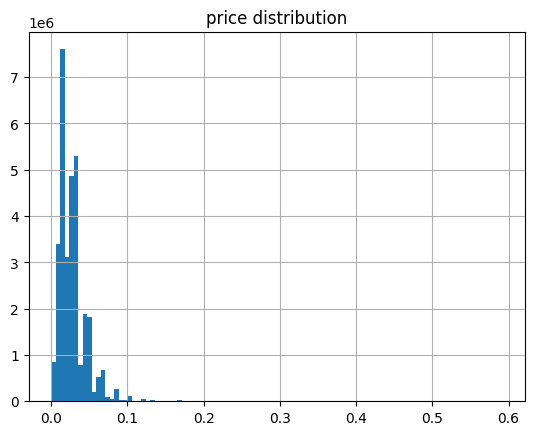

In [19]:
transactions.price.hist(bins=100)
plt.title('price distribution')

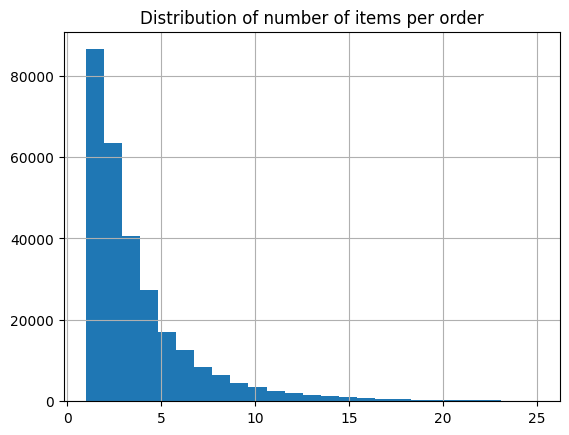

In [26]:
baskets = transactions.head(1_000_000).groupby(['t_dat', 'customer_id'])
baskets.apply(len).hist(bins=25, range=[1,25])
plt.title('Distribution of number of items per order')
plt.show()

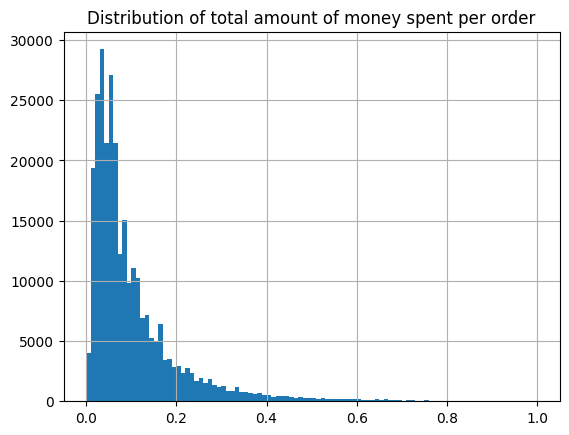

In [27]:
baskets.apply(lambda b: b.price.sum()).hist(bins=100, range=[0,1])
plt.title('Distribution of total amount of money spent per order')
plt.show()

In [28]:
transactions.sales_channel_id.value_counts()

2    22379862
1     9408462
Name: sales_channel_id, dtype: int64

### 1.1 Seasonality trends

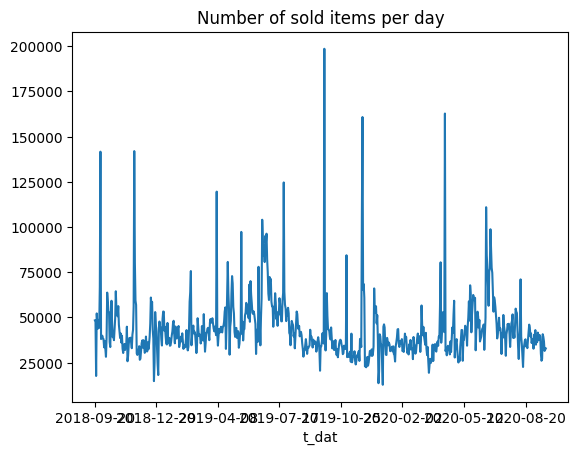

In [29]:
## seasonality of all item sales:
transactions.groupby('t_dat').apply(len).plot()
plt.title('Number of sold items per day')
plt.show()


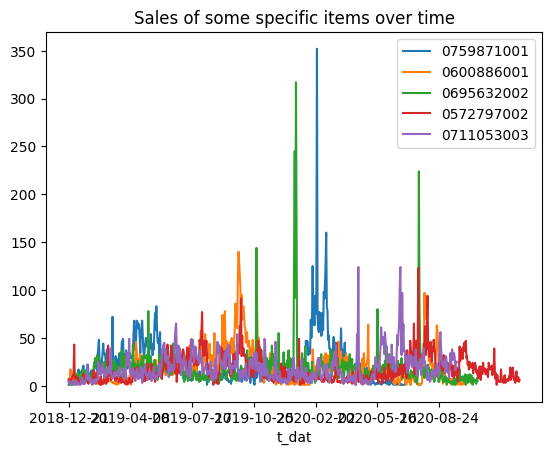

In [32]:
## seasonality of specific items

## 1. select a commonly purchased item:
items = transactions.article_id.value_counts().index[50:55]

## 2. plot item sales over time
for item in items:
    item_sales = transactions[transactions.article_id == item]
    item_sales.groupby('t_dat').apply(len).plot()
plt.title(f'Sales of some specific items over time')
plt.legend(items)
plt.show()

### 1.2 Out of the transactions what percentage are:
1. new and unique?
2. user's first transaction?
3. re-buying already bought item?

In [9]:
last_week_transactions = transactions[transactions.t_dat.between('2020-09-15', '2020-09-22')]
prev_transactions = transactions[transactions.t_dat < '2020-09-15']

def kind_of_order(customer_id: str, article_id: str, prev_transactions: pd.DataFrame) -> str:
    '''
    Given a customer id, and an article, and previous transactions, 
    classify the article into one of {'first ever', 're-bought', 'new item'}
    '''
    
    user_txns = prev_transactions[prev_transactions.customer_id == customer_id]
    if len(user_txns) == 0:
        return 'first ever'
    if article_id in user_txns.article_id:
        return 're-bought'
    return 'new item'

In [22]:
subset_users = transactions.customer_id.sample(5000).unique()
last_week_subset = last_week_transactions[last_week_transactions.customer_id.isin(subset_users)]
prev_txns_subset = prev_transactions[prev_transactions.customer_id.isin(subset_users)]
print(f'We are counting for a subset of {len(last_week_subset)} items')
order_classes = {}
for id_, row in tqdm(last_week_subset.iterrows()):
    order_classes[id_] = kind_of_order(row.customer_id, 
                                       row.article_id,
                                       prev_txns_subset)    

We are counting for a subset of 3552 items


3552it [02:07, 27.84it/s]


In [26]:
pd.Series(order_classes).value_counts(normalize=True)

new item      0.996622
first ever    0.003378
dtype: float64

## 2. Articles

In [21]:
articles = pd.read_csv('data/articles.csv')
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [14]:
articles.prod_name.value_counts()

Dragonfly dress                98
Mike tee                       72
Wow printed tee 6.99           70
1pk Fun                        55
TP Paddington Sweater          54
                               ..
W MARCIE DRESS CNY              1
W NAPOLI SKIRT CNY              1
BEANIE JERSEY FLEECED LINED     1
H-string multicolour            1
Lounge dress                    1
Name: prod_name, Length: 45875, dtype: int64

In [15]:
articles.product_group_name.value_counts()

Garment Upper body       42741
Garment Lower body       19812
Garment Full body        13292
Accessories              11158
Underwear                 5490
Shoes                     5283
Swimwear                  3127
Socks & Tights            2442
Nightwear                 1899
Unknown                    121
Underwear/nightwear         54
Cosmetic                    49
Bags                        25
Items                       17
Furniture                   13
Garment and Shoe care        9
Stationery                   5
Interior textile             3
Fun                          2
Name: product_group_name, dtype: int64

In [16]:
articles.product_type_name.value_counts()

Trousers         11169
Dress            10362
Sweater           9302
T-shirt           7904
Top               4155
                 ...  
Keychain             1
Headband             1
Cushion              1
Blanket              1
Clothing mist        1
Name: product_type_name, Length: 131, dtype: int64

In [17]:
articles.graphical_appearance_name.value_counts()

Solid                  49747
All over pattern       17165
Melange                 5938
Stripe                  4990
Denim                   4842
Front print             3215
Placement print         3098
Check                   2178
Colour blocking         1830
Lace                    1513
Other structure         1502
Application/3D          1341
Embroidery              1165
Mixed solid/pattern     1132
Glittering/Metallic      958
Jacquard                 830
Sequin                   806
Dot                      681
Treatment                586
Other pattern            515
Contrast                 376
Metallic                 346
Chambray                 322
Slub                     153
Transparent               86
Mesh                      86
Neps                      66
Unknown                   52
Argyle                    15
Hologram                   8
Name: graphical_appearance_name, dtype: int64

In [19]:
articles.colour_group_name.value_counts()

Black              22670
Dark Blue          12171
White               9542
Light Pink          5811
Grey                4487
Light Beige         3356
Blue                3308
Red                 3056
Light Blue          3012
Greenish Khaki      2767
Dark Grey           2731
Off White           2726
Beige               2712
Dark Red            2340
Dark Green          2106
Light Grey          2105
Pink                2063
Yellow              1645
Light Orange        1520
Yellowish Brown     1471
Gold                1377
Dark Beige          1084
Light Turquoise     1027
Light Yellow         984
Dark Orange          886
Dark Pink            818
Green                815
Orange               779
Other Pink           750
Silver               709
Light Green          681
Dark Yellow          574
Light Purple         553
Dark Turquoise       473
Turquoise            435
Dark Purple          315
Light Red            285
Greyish Beige        226
Other Yellow         225
Purple               182


In [23]:
articles.perceived_colour_value_name.value_counts()

Dark            42706
Dusty Light     22152
Light           15739
Medium Dusty    12630
Bright           6471
Medium           5711
Undefined         105
Unknown            28
Name: perceived_colour_value_name, dtype: int64

In [25]:
articles.perceived_colour_master_name.value_counts()

Black              22585
Blue               18469
White              12665
Pink                9403
Grey                8924
Red                 5878
Beige               5657
Green               3526
Khaki green         3181
Yellow              3121
Orange              2734
Brown               2269
Metal               2180
Turquoise           1829
Mole                1223
Lilac Purple        1100
Unknown              685
undefined            105
Yellowish Green        5
Bluish Green           3
Name: perceived_colour_master_name, dtype: int64

In [30]:
def convert_colour_to_numeric(color_name: str, encoding: str='rgb') -> Tuple[int, int, int]:
    '''
    
    Given a colour name, attempts to encode it as a tuple of integers, 
    representing the colour's RGB or HSV values
    '''
    
    
    return 0, 0, 0

convert_colour_to_numeric('black', encoding='hsv')

(0, 0, 0)

In [35]:
articles.detail_desc.nunique()

43404

Text(0.5, 1.0, 'number of characters in item description')

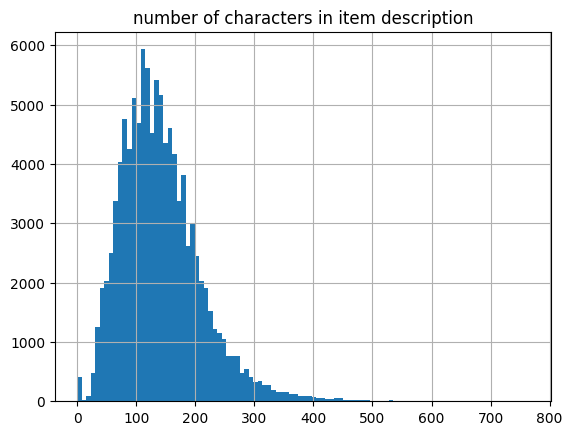

In [40]:
articles.detail_desc.fillna('').apply(len).hist(bins=100)
plt.title('number of characters in item description')

## 3. Customers

In [2]:
customers = pd.read_csv('data/customers.csv')
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


Text(0.5, 1.0, 'Customer age counts')

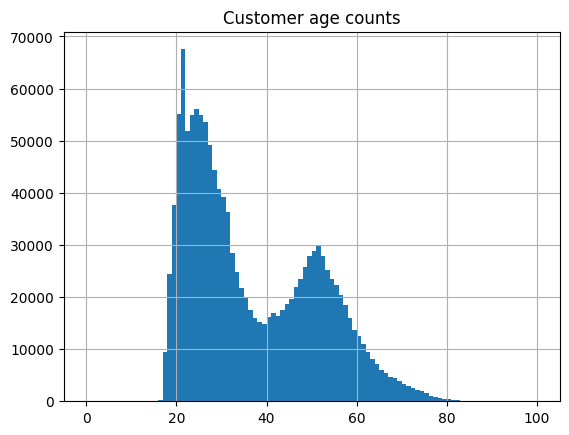

In [62]:
customers.age.hist(bins=100, range=[0,100])
plt.title('Customer age counts')

In [63]:
customers.postal_code.nunique()

352899

In [64]:
customers.fashion_news_frequency.value_counts()

NONE         877711
Regularly    477416
Monthly         842
None              2
Name: fashion_news_frequency, dtype: int64

In [66]:
customers.FN.value_counts(dropna=False)

NaN    895050
1.0    476930
Name: FN, dtype: int64

In [67]:
customers.Active.value_counts(dropna=False)

NaN    907576
1.0    464404
Name: Active, dtype: int64

In [68]:
customers.club_member_status.value_counts(dropna=False)

ACTIVE        1272491
PRE-CREATE      92960
NaN              6062
LEFT CLUB         467
Name: club_member_status, dtype: int64

In [37]:
# what percentage in customers are in postal codes with at least k customers?

num_customers = len(customers)
postal_code_counts = customers.postal_code.value_counts()
for threshold in [3, 5, 10, 100, 1000]:
    common_postal_codes = postal_code_counts[postal_code_counts > threshold]
    common_postal_code_users = common_postal_codes.sum()
    print(f'{(common_postal_code_users/num_customers*100):.2f}% of users are in a postal code with at least {threshold} users')

69.98% of users are in a postal code with at least 3 users
47.51% of users are in a postal code with at least 5 users
21.31% of users are in a postal code with at least 10 users
8.91% of users are in a postal code with at least 100 users
8.77% of users are in a postal code with at least 1000 users
